In [1]:
import nltk
import pandas as pd
import numpy as np
import re

from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced
from nltk.tokenize import RegexpTokenizer
import io

%matplotlib inline
import matplotlib.pyplot as plt


# Loading Data

In [2]:
data = pd.read_csv("./Sheet_1.csv",usecols=['response_id','class','response_text'],encoding='latin-1')
data = shuffle(data, random_state=12345)
labels = np.asarray(data['class']== 'flagged',dtype=int)
data = data[['response_text','class']]
data.describe()


,response_text,class
count,80,80
unique,80,2
top,Friends often come to me to talk about the iss...,not_flagged
freq,1,55


# Text preprocessing

In [3]:

#wpt = nltk.WordPunctTokenizer()
wpt = nltk.RegexpTokenizer(r'\w+')
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-z,A-Z\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
normed_data = normalize_corpus(data['response_text'])

# Loading and retrieve Vectors
To generate word level features, pretrained word2vec model from Fasttext is used. This model is trained CommonCrawl corpus and has 2M word_vectors. 

In [4]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

word_vectors = load_vectors('./word_2_vec_model/crawl-300d-2M.vec')

In [5]:
# retrieve vectors for all tokens.
data_vectors = []
for i, sentence in enumerate(normed_data):
    words = sentence.split(' ')
    vectors=[]
    for w in words:
        if w in word_vectors.keys():
            vectors.append(word_vectors[w])
        else:
            print("Word {} not in vocab".format(w))
    data_vectors.append(vectors)
    if i % 10 ==0:
        print 'Done with %d' % i

Done with 0
Done with 10
Done with 20
Word virgity not in vocab
Done with 30
Word theripist not in vocab
Done with 40
Done with 50
Word cuttersuicidal not in vocab
Done with 60
Word irlsomeone not in vocab
Word campingsurfing not in vocab
Done with 70
Word geds not in vocab


# Generating Features
Here sentence(sample) level features are generated by taking mean of token-words in the sentence.

In [6]:
features = []
for vv in data_vectors:
    features.append(np.mean(vv,axis=0 ))
features= np.asarray(features)

In [7]:
## Util for Confusion Matrix - Taken from sklearn doc.
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Training
For training, 5-fold crossvalidation is employed since we have very less data to play with. These folds are startified since there is significant imbalance between not_flagged(0) and flagged(1) classes. In each of the fold, grid search is performend on train/val set to find best hyper parameters(C). ATM only SVM is used as classifier.


Fold 0 Report
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.73      1.00      0.84      0.85      0.71        11
          1       0.62      1.00      0.73      0.77      0.85      0.75         5

avg / total       0.88      0.81      0.91      0.82      0.85      0.72        16

Best Classfier
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
.....
Fold 1 Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      1.00      0.80      0.96      0.89      0.82        11
          1       1.00      0.80      1.00      0.89      0.89      0.78         5

avg / total       0.94      0.94      0.86      0.94      0.89      0.81        16

Best Classfier
SVC(C=100, cache_size=200, class_weight=N

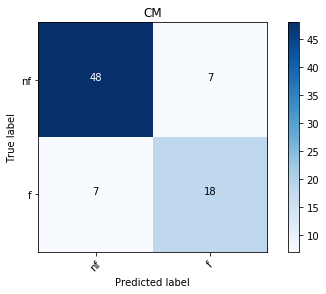

In [8]:
from sklearn.model_selection import GridSearchCV


skf = StratifiedKFold(n_splits=5, random_state=1234, shuffle=False)
y_test_all, y_pred_all = [],[]

for i, [train_index, test_index] in enumerate(skf.split(features,labels)):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Over sample to balance the classes.
    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_sample(X_train, y_train)
    
    # Grid search
    h_parameters = {'C':[0.01, 0.1, 1, 10, 100, 1000]}
    svc = svm.SVC(kernel='rbf')
    clf = GridSearchCV(svc, h_parameters)
    clf.fit(X_res, y_res)

    #prediction on test-fold
    y_pred = clf.best_estimator_.predict(X_test)
    y_test_all.extend(y_test)
    y_pred_all.extend(y_pred)
    print 'Fold %d Report' % i
    print(classification_report_imbalanced(y_test, y_pred))
    print 'Best Classfier'
    print clf.best_estimator_
    print '.....'

print 'Combining test prediction of all folds:'
print(classification_report_imbalanced(y_test_all, y_pred_all))
plt.figure()
cnf_matrix = confusion_matrix(y_test_all, y_pred_all)
plot_confusion_matrix(cnf_matrix, classes=['nf','f'],
                  title='CM')
plt.show()

In [9]:
print 'Accuracy:', np.sum(np.asarray(y_test_all)==np.asarray(y_pred_all))/float(len(y_pred_all))

Accuracy: 0.825


# Next Step:
 - weight the word_vectors using tfidf scores while combining them to form sample-level features
 - LSTMs